In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
import os
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import make_moons
import cv2 as cv
from keras.models import Sequential
from keras.layers import Dense, Flatten,Dropout
from keras import layers


In [2]:
data_path = 'seg_train\seg_train'  
data_path_for_test = 'seg_test\seg_test'

In [3]:
image_dimensions = (64, 64)  
def load_and_process_images(path):
    images = []  
    labels = []  
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)  
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file)  
                try:
                    image = Image.open(image_path)
                    image = image.resize(image_dimensions)
                    image = image.convert('L') 
                    images.append(np.array(image))
                    labels.append(folder)
                except Exception as e:
                    print("خطأ في قراءة الصورة:", image_path)
                    print(e)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [4]:
images, labels = load_and_process_images(data_path)
images = images.astype('float32') / 255

label_to_number = {label: number for number, label in enumerate(np.unique(labels))}
labels = np.array([label_to_number[label] for label in labels])
labels = to_categorical(labels)
images = np.array(images).reshape(14034, 64* 64)

In [5]:
images_test, labels_test = load_and_process_images(data_path_for_test)
images_test = images_test.astype('float32') / 255

label_to_number_test = {label: number for number, label in enumerate(np.unique(labels_test))}
labels_test = np.array([label_to_number_test[label] for label in labels_test])
labels_test = to_categorical(labels_test)
images_test = np.array(images_test).reshape(3000, 64* 64 )

In [6]:
print(images.shape)
print(images_test.shape)

(14034, 4096)
(3000, 4096)


In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [66]:
def sigmoid_derivative(x):
    return x * (1 - x)

In [69]:
class NeuralNetwork:
   
    # constructor for this VERY particular network with 2 layers (plus one for input) # one hidden layer
    
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],20)
        self.weights2   = np.random.rand(20, 10)                  
        self.weights3   = np.random.rand(10, 5) 
        self.weights4   = np.random.rand(5,len(label_to_number)) 
        self.y          = y
        self.output     = np.zeros(self.y.shape)
        self.loss       = []

    def calculate_accuracy(self, predictions, targets):
        # تحويل التنبؤات إلى الفئات الحقيقية (أكبر قيمة في كل صف)
        prediction_classes = np.argmax(predictions, axis=1)
        target_classes = np.argmax(targets, axis=1)

        # حساب عدد التنبؤات الصحيحة
        correct_predictions = np.sum(prediction_classes == target_classes)

        # حساب الدقة
        accuracy = correct_predictions / len(targets)
        return accuracy

    # the function that computs the output of the network for some input
    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input,self.weights1))
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2))
        self.layer3 = sigmoid(np.dot(self.layer2, self.weights3))
        self.output = sigmoid(np.dot(self.layer3,self.weights4))
        return self.output

    # the backpropagation algorithm 
    def backprop(self, l_rate):
        error_output = 2 * (self.y - self.output) * sigmoid_derivative(self.output)
        d_weights4 = np.dot(self.layer3.T, error_output)

        error_layer3 = np.dot(error_output, self.weights4.T) * sigmoid_derivative(self.layer3)
        d_weights3 = np.dot(self.layer2.T, error_layer3)

        error_layer2 = np.dot(error_layer3, self.weights3.T) * sigmoid_derivative(self.layer2)
        d_weights2 = np.dot(self.layer1.T, error_layer2)

        error_layer1 = np.dot(error_layer2, self.weights2.T) * sigmoid_derivative(self.layer1)
        d_weights1 = np.dot(self.input.T, error_layer1)

        self.weights1 += l_rate * d_weights1
        self.weights2 += l_rate * d_weights2
        self.weights3 += l_rate * d_weights3
        self.weights4 += l_rate * d_weights4
        

        
        self.loss.append(sum(np.power(self.y - self.output,2)))

[[5.82030132e-092 3.76037628e-122 3.57335646e-116 1.07945445e-047
  7.66941979e-087 5.75567192e-053]
 [5.82030132e-092 3.76037628e-122 3.57335646e-116 1.07945445e-047
  7.66941979e-087 5.75567192e-053]
 [5.82030132e-092 3.76037628e-122 3.57335646e-116 1.07945445e-047
  7.66941979e-087 5.75567192e-053]
 ...
 [5.82030132e-092 3.76037628e-122 3.57335646e-116 1.07945445e-047
  7.66941979e-087 5.75567192e-053]
 [5.82030132e-092 3.76037628e-122 3.57335646e-116 1.07945445e-047
  7.66941979e-087 5.75567192e-053]
 [5.82030132e-092 3.76037628e-122 3.57335646e-116 1.07945445e-047
  7.66941979e-087 5.75567192e-053]]


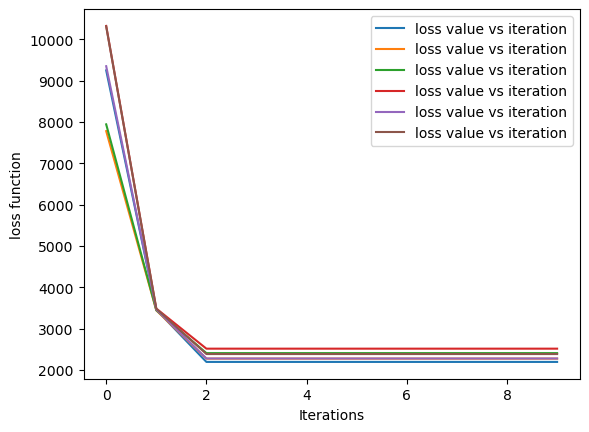

In [71]:
nn = NeuralNetwork(images,labels)
nn.loss=[]
iterations =[]

for i in range(10):
    nn.feedforward()
    nn.backprop(l_rate=0.1)
    iterations.append(i)

print(nn.output)
nn.loss = np.array(nn.loss)

plt.plot(iterations, nn.loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

In [72]:
predictions = nn.feedforward()
acc = nn.calculate_accuracy(predictions, nn.y)
print(f"دقة الشبكة: {acc}")

دقة الشبكة: 0.17899387202508193


In [ ]:
import numpy as np

def rprop(X, y, n_iter, eta_plus=1.2, eta_minus=0.5, delta_max=50, delta_min=1e-6):
    n_samples, n_features = X.shape

    # تهيئة الأوزان وتحديثات الخطوة
    weights = np.random.randn(n_features)
    delta_weights = np.full(n_features, 0.1)

    # تخزين المشتقات الجزئية السابقة
    prev_gradient = np.zeros(n_features)

    for i in range(n_iter):
        # حساب المشتق الجزئي للخطأ بالنسبة لكل وزن
        predictions = np.dot(X, weights)
        errors = predictions - y
        gradient = np.dot(X.T, errors)

        for j in range(n_features):
            grad_sign = np.sign(gradient[j] * prev_gradient[j])
            if grad_sign > 0:
                # زيادة الخطوة
                delta_weights[j] = min(delta_weights[j] * eta_plus, delta_max)
            elif grad_sign < 0:
                # تقليل الخطوة وإعادة تعيين المشتق الجزئي
                delta_weights[j] = max(delta_weights[j] * eta_minus, delta_min)
                gradient[j] = 0

        # تحديث الأوزان
        weights -= np.sign(gradient) * delta_weights
        prev_gradient = gradient

    return weights

# بيانات تجريبية
X = np.array([[0.1, 0.4], [0.3, 0.9], [0.5, 0.2], [0.7, 0.8]])
y = np.array([0.3, 0.9, 0.5, 0.7])

# تشغيل RPROP
weights = rprop(X, y, n_iter=100)
print("أوزان المُحدثة:", weights)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# تعريف الشبكة العصبية
class BayesianNeuralNetwork(nn.Module):
    def __init__(self):
        super(BayesianNeuralNetwork, self).__init__()
        # تعريف الطبقات
        self.fc1 = nn.Linear(in_features=784, out_features=400)  # 784 هو حجم الإدخال, 400 عقدة في الطبقة الأولى
        self.fc2 = nn.Linear(in_features=400, out_features=10)   # 10 هو عدد الفئات الناتجة

    def forward(self, x):
        # تطبيق الطبقات ودالة التفعيل
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# إنشاء كائن الشبكة
model = BayesianNeuralNetwork()

# بيانات الإدخال (مثال)
input_data = torch.randn(1, 784)  # 1 هو عدد العينات, 784 هو حجم كل عينة

# التنبؤ
output = model(input_data)
print(output)


In [45]:
from keras.backend import clear_session
clear_session()

In [46]:
model = Sequential()

model.add(Dense(512,input_dim=images.shape[1] , activation='relu'))  
# model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))  
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu')) 
model.add(Dense(64, activation='relu'))  
model.add(Dense(32, activation='relu'))  
model.add(Dense(16, activation='relu'))  
model.add(Dense(8, activation='relu'))
model.add(Dense(len(label_to_number), activation='softmax')) 


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2097664   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 1

In [47]:
history = model.fit(images, labels, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
395/395 [==============================] - 11s 24ms/step - loss: 1.7087 - accuracy: 0.2238 - val_loss: 1.9722 - val_accuracy: 0.0000e+00
Epoch 2/10
395/395 [==============================] - 9s 22ms/step - loss: 1.6230 - accuracy: 0.3041 - val_loss: 2.2694 - val_accuracy: 0.0798
Epoch 3/10
395/395 [==============================] - 9s 23ms/step - loss: 1.5862 - accuracy: 0.3451 - val_loss: 1.8297 - val_accuracy: 0.2635
Epoch 4/10
395/395 [==============================] - 9s 22ms/step - loss: 1.5416 - accuracy: 0.3610 - val_loss: 1.7689 - val_accuracy: 0.2350
Epoch 5/10
395/395 [==============================] - 9s 22ms/step - loss: 1.5062 - accuracy: 0.3799 - val_loss: 1.7745 - val_accuracy: 0.2578
Epoch 6/10
395/395 [==============================] - 9s 22ms/step - loss: 1.4515 - accuracy: 0.4120 - val_loss: 1.9698 - val_accuracy: 0.2407
Epoch 7/10
395/395 [==============================] - 9s 22ms/step - loss: 1.4218 - accuracy: 0.4300 - val_loss: 2.1493 - val_accuracy: 0

In [48]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 0s 4ms/step - loss: 1.3953 - accuracy: 0.4487
Loss: 1.395344614982605, Accuracy: 0.44866666197776794


In [49]:
history = model.fit(images, labels, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
790/790 [==============================] - 20s 25ms/step - loss: 1.3756 - accuracy: 0.4619 - val_loss: 2.2023 - val_accuracy: 0.2806
Epoch 2/10
790/790 [==============================] - 17s 21ms/step - loss: 1.3509 - accuracy: 0.4685 - val_loss: 2.0235 - val_accuracy: 0.3027
Epoch 3/10
790/790 [==============================] - 17s 21ms/step - loss: 1.3303 - accuracy: 0.4769 - val_loss: 2.2398 - val_accuracy: 0.1966
Epoch 4/10
790/790 [==============================] - 20s 26ms/step - loss: 1.3224 - accuracy: 0.4792 - val_loss: 1.9484 - val_accuracy: 0.2842
Epoch 5/10
790/790 [==============================] - 23s 30ms/step - loss: 1.2970 - accuracy: 0.4906 - val_loss: 1.8704 - val_accuracy: 0.3476
Epoch 6/10
790/790 [==============================] - 20s 25ms/step - loss: 1.2915 - accuracy: 0.4939 - val_loss: 1.9878 - val_accuracy: 0.2593
Epoch 7/10
790/790 [==============================] - 19s 24ms/step - loss: 1.2859 - accuracy: 0.4975 - val_loss: 1.9543 - val_accuracy:

In [50]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 0s 4ms/step - loss: 1.4771 - accuracy: 0.4260
Loss: 1.4771076440811157, Accuracy: 0.4259999990463257


In [51]:
history = model.fit(images, labels, epochs=100, batch_size=10, validation_split=0.1)

Epoch 1/100
1263/1263 [==============================] - 32s 26ms/step - loss: 1.2767 - accuracy: 0.4987 - val_loss: 1.7781 - val_accuracy: 0.4095
Epoch 2/100
1263/1263 [==============================] - 35s 28ms/step - loss: 1.2572 - accuracy: 0.5071 - val_loss: 1.8998 - val_accuracy: 0.3697
Epoch 3/100
1263/1263 [==============================] - 28s 22ms/step - loss: 1.2465 - accuracy: 0.5116 - val_loss: 2.5698 - val_accuracy: 0.1802
Epoch 4/100
1263/1263 [==============================] - 32s 25ms/step - loss: 1.2343 - accuracy: 0.5186 - val_loss: 1.8536 - val_accuracy: 0.3205
Epoch 5/100
1263/1263 [==============================] - 31s 24ms/step - loss: 1.2261 - accuracy: 0.5184 - val_loss: 1.7618 - val_accuracy: 0.3020
Epoch 6/100
1263/1263 [==============================] - 29s 23ms/step - loss: 1.2106 - accuracy: 0.5256 - val_loss: 2.0868 - val_accuracy: 0.2877
Epoch 7/100
1263/1263 [==============================] - 27s 22ms/step - loss: 1.2033 - accuracy: 0.5280 - val_loss: 2

In [52]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 0s 4ms/step - loss: 2.2436 - accuracy: 0.4600
Loss: 2.2435977458953857, Accuracy: 0.46000000834465027


In [54]:
history = model.fit(images, labels, epochs=1000, batch_size=64, validation_split=0.1)

Epoch 1/1000
198/198 [==============================] - 6s 29ms/step - loss: 0.5330 - accuracy: 0.7934 - val_loss: 3.8194 - val_accuracy: 0.3412
Epoch 2/1000
198/198 [==============================] - 5s 27ms/step - loss: 0.5080 - accuracy: 0.8029 - val_loss: 4.0895 - val_accuracy: 0.3376
Epoch 3/1000
198/198 [==============================] - 5s 23ms/step - loss: 0.4931 - accuracy: 0.8078 - val_loss: 4.3079 - val_accuracy: 0.3248
Epoch 4/1000
198/198 [==============================] - 5s 24ms/step - loss: 0.4858 - accuracy: 0.8098 - val_loss: 4.1794 - val_accuracy: 0.3540
Epoch 5/1000
198/198 [==============================] - 5s 23ms/step - loss: 0.4830 - accuracy: 0.8095 - val_loss: 4.2709 - val_accuracy: 0.3433
Epoch 6/1000
198/198 [==============================] - 5s 24ms/step - loss: 0.4797 - accuracy: 0.8110 - val_loss: 4.1075 - val_accuracy: 0.3697
Epoch 7/1000
198/198 [==============================] - 5s 23ms/step - loss: 0.4790 - accuracy: 0.8111 - val_loss: 4.1800 - val_ac

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')